### Setup the Spark VM and complete the below assignment

Objective:- Build a ML model to predict the employee compensation.
The application should be modelled using Spark.

You can refer to the below links for spark commands:- 
- https://spark.apache.org/docs/latest/ml-pipeline.html

- https://github.com/spark-in-action/first-edition

- https://github.com/FavioVazquez/first_spark_model

# Predicting Employee Compensation

## Data Dictionary
<br>**Year Type** - Fiscal (July through June) or Calendar (January through December)
<br>**Year** - An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012.
<br>**Organization Group Code** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,Fire, Adult Probation, District Attorney, and Sheriff.
<br> **Organization Group** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,
Fire, Adult Probation, District Attorney, and Sheriff.
<br>**Department Code** - Departments are the primary organizational unit used by the Cityand County of San Francisco. Examples include Recreation and
Parks, Public Works, and the Police Department.
<br>**Department Code** - Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
<br>**Union Code** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Union** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Job Family Code** Job Family combines similar Jobs into meaningful groups.
<br>**Job Family** Job Family combines similar Jobs into meaningful groups.
<br>**Employee Identifier** Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the
Employee Compensation report hosted on openbook.sfgov.org,
but that report does show one row for each employee. Employee
ID has been included here to allow users to reconstruct the
original report. Note that each employee’s identifier will change
each time this dataset is updated, so comparisons by employee
across multiple versions of the dataset are not possible.
<br>**Salaries** - Normal salaries paid to permanent or temporary City employees.
<br>**Overtime** - Amounts paid to City employees working in excess of 40 hours
per week.
<br>**Other Salaries** - Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments. Total Salary Number The sum of all salaries paid to City employees.
<br>**Retirement** City contributions to employee retirement plans.
<br>**Health/Dental** City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
<br>**Other Benefits** Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment
insurance premiums, and minor discretionary benefits not included in the above categories.
<br>**Total Benefits** The sum of all benefits paid to City employees.
<br>**Total Compensation** The sum of all salaries and benefits paid to City employees.

Read the data and answer the following questions to predict employee compensation

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, Imputer, VectorIndexer
from pyspark.ml import PipelineModel
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.functions import lit
import seaborn as sns

In [0]:
spark = SparkSession \
    .builder \
    .appName('Employee Compensation') \
    .getOrCreate()

## 1. Read the Data

In [0]:
emp_com_df = spark.read.csv('/FileStore/tables/Employee_Compensation.csv', header= True)

In [0]:
display(emp_com_df)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Fiscal,2016,01,Public Protection,DAT,District Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),49919,114473.16,0,1500,115973.16,21025.98,13068.8,9368.71,43463.49,159436.65
Calendar,2013,05,Culture & Recreation,ART,Arts Commission,790,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1844,Senior Management Assistant,1225,84077.11,0,0,84077.11,16587.3,12457.73,6931.91,35976.94,120054.05
Calendar,2015,04,Community Health,DPH,Public Health,535,"SEIU - Human Services, Local 1021",2900,Human Services,2903,Eligibility Worker,34873,9980.17,0,798.43,10778.6,0,2254.93,835.11,3090.04,13868.64
Fiscal,2015,04,Community Health,DPH,Public Health,250,"SEIU - Health Workers, Local 1021",2200,Medical & Dental,2202,Dental Aide,51145,2873.41,0,0,2873.41,0,622.63,222.46,845.09,3718.5
Fiscal,2014,05,Culture & Recreation,REC,Recreation and Park Commission,790,"SEIU - Miscellaneous, Local 1021",3200,Recreation,3279,Recreation Leader,48705,6701.85,0,176.7,6878.55,0,2711.66,538.43,3250.09,10128.64
Fiscal,2013,02,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,021,"Prof & Tech Engineers - Miscellaneous, Local 21",5300,Sub-Professional Engineering,5380,"Stdntdsgntrain1, Arch/Eng/Plng",19801,45321.18,0,0,45321.18,9386.03,11780.6,3486.34,24652.97,69974.15
Fiscal,2015,05,Culture & Recreation,LIB,Public Library,790,"SEIU - Miscellaneous, Local 1021",3600,Library,3610,Library Assistant,14135,28305.5,0,1193.14,29498.64,6616.52,5793.48,2430.74,14840.74,44339.38
Fiscal,2014,06,General Administration & Finance,ASR,Assessor/Recorder,021,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,Appraisal & Taxation,4261,Real Property Appraiser,37352,39938.09,0,800,40738.09,8685.34,7269.02,3277.52,19231.88,59969.97
Calendar,2015,01,Public Protection,POL,Police,911,Police Officers' Association,Q000,Police Services,Q060,Lieutenant (Police Department),13380,23112,2312.73,20944.16,46368.89,4183.12,1911.46,68.84,6163.42,52532.31
Fiscal,2014,01,Public Protection,SHF,Sheriff,498,Deputy Sheriffs' Association,8300,Correction & Detention,8304,Deputy Sheriff,46569,89101.22,6856.77,5563.78,101521.77,17596.33,12512.55,1627.91,31736.79,133258.56


### 1.1 Display the number of rows and columns in the dataset

In [0]:
print("Number of rows : ",emp_com_df.count() ,"\nNumber of columns : ", len(emp_com_df.columns))

Number of rows : 291825 
Number of columns : 22

### 1.2 Check the datatype of the variables

In [0]:
emp_com_df.printSchema()

root
-- Year Type: string (nullable = true)
-- Year: string (nullable = true)
-- Organization Group Code: string (nullable = true)
-- Organization Group: string (nullable = true)
-- Department Code: string (nullable = true)
-- Department: string (nullable = true)
-- Union Code: string (nullable = true)
-- Union: string (nullable = true)
-- Job Family Code: string (nullable = true)
-- Job Family: string (nullable = true)
-- Job Code: string (nullable = true)
-- Job: string (nullable = true)
-- Employee Identifier: string (nullable = true)
-- Salaries: string (nullable = true)
-- Overtime: string (nullable = true)
-- Other Salaries: string (nullable = true)
-- Total Salary: string (nullable = true)
-- Retirement: string (nullable = true)
-- Health/Dental: string (nullable = true)
-- Other Benefits: string (nullable = true)
-- Total Benefits: string (nullable = true)
-- Total Compensation: string (nullable = true)

In [0]:
emp_com_df.describe().toPandas()

Out[323]:

,summary,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,count,291825,291825,291825,291825,291825,291825,291782,291782,291780,291780,291825,291825,291825,291825,291825,291825,291825,291825,291825,291825,291825,291825
1,mean,None,2014.325061252463,2.9770513150004283,None,None,None,489.5060764543392,None,4778.5595401977025,None,4911.798751534337,None,26917.83031611411,63210.17288679845,4406.877439766983,3781.0328698706558,71398.0831964368,12937.728957114718,8921.893731723338,4644.276406956207,26503.899095793717,97901.98229223007
2,stddev,None,1.0322652725499357,1.577770926531507,None,None,None,333.7611361507335,None,3090.2831717442596,None,3128.4123150253013,None,15548.201986568676,44660.46230493871,11079.405928192713,7697.665317297403,52224.21409875056,9785.064808401636,4900.318082757248,3787.907010421279,16800.143146559007,67777.54915227593
3,min,Calendar,2013,01,Community Health,AAM,Academy of Sciences,001,"Automotive Machinists, Local 1414",0900,Administrative & Mgmt (Unrep),0109,Account Clerk,1,-0.25,-0.01,-102.73,-0.25,-0.01,-0.06,-0.01,-0.01,-0.01
4,max,Fiscal,2016,07,"Public Works, Transportation & Commerce",WTR,War Memorial,990,"Transportation Workers, Local 200",SFRA,Supervisory-Labor & Trade,Q082,Youth Comm Advisor,9999,99998.02,9999.42,9999.78,99999.31,9999.9,9999.97,9999.76,9999.57,99998.65


* We observe that all the columns have data type as string. This may be due to few None Null NA values in the columns.
* The columns 'Year', 'Organization Group Code', 'Union Code', 'Employee Identifier','Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement','Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation' have to be converted to Integer data type

### 2. Convert the incorrect column type into its suitable column type. And drop the redundant features

In [0]:
# columns to be modified to integer datatype
columns_to_convert_to_integer = ['Year', 'Organization Group Code', 'Union Code', 'Employee Identifier','Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement','Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation']

# changing the datatype to integer
for column in columns_to_convert_to_integer:
  emp_com_df = emp_com_df.withColumn(column, emp_com_df[column].cast(IntegerType()))
  
# displaying schema after modifying datatype
emp_com_df.printSchema()

root
-- Year Type: string (nullable = true)
-- Year: integer (nullable = true)
-- Organization Group Code: integer (nullable = true)
-- Organization Group: string (nullable = true)
-- Department Code: string (nullable = true)
-- Department: string (nullable = true)
-- Union Code: integer (nullable = true)
-- Union: string (nullable = true)
-- Job Family Code: string (nullable = true)
-- Job Family: string (nullable = true)
-- Job Code: string (nullable = true)
-- Job: string (nullable = true)
-- Employee Identifier: integer (nullable = true)
-- Salaries: integer (nullable = true)
-- Overtime: integer (nullable = true)
-- Other Salaries: integer (nullable = true)
-- Total Salary: integer (nullable = true)
-- Retirement: integer (nullable = true)
-- Health/Dental: integer (nullable = true)
-- Other Benefits: integer (nullable = true)
-- Total Benefits: integer (nullable = true)
-- Total Compensation: integer (nullable = true)

### 3. Check basic statistics and perform necessary data preprocessing (Like removing negative amount)

In [0]:
integer_columns = ['Year', 'Organization Group Code', 'Union Code', 'Employee Identifier','Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement','Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation']

display(emp_com_df.select(integer_columns).describe())

summary,Year,Organization Group Code,Union Code,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
count,291825,291825,291782,291825,291825,291825,291825,291825,291825,291825,291825,291825,291825
mean,2014.325061252463,2.9770513150004283,489.5060764543392,26917.83031611411,63209.77205517005,4406.6679825237725,3780.7362186241753,71397.6304977298,12937.31302321597,8921.38888032211,4643.785357662983,26503.405407350296,97901.48851880408
stddev,1.0322652725499357,1.577770926531507,333.7611361507335,15548.201986568676,44660.46317546176,11079.292424637566,7697.575733523244,52224.20455345998,9784.95959243722,4900.249584658956,3787.9027127322897,16800.13895106104,67777.54705845448
min,2013,1,1,1,-68771,-12308,-19131,-68771,-30621,-2940,-10636,-21295,-74082
max,2016,7,990,53794,515101,227313,342802,515101,105052,21872,35157,141043,653498


* We observed there are negative salaries for 80 records, which we will remove, as these are data entry issues

In [0]:
emp_com_df = emp_com_df.filter((emp_com_df['Salaries']>=0) & (emp_com_df['Overtime']>=0) & (emp_com_df['Other Salaries']>=0)  & (emp_com_df['Total Compensation']>=0) & (emp_com_df['Total Salary']>=0) & (emp_com_df['Retirement']>=0) & (emp_com_df['Health/Dental']>=0) & (emp_com_df['Other Benefits']>=0) & (emp_com_df['Total Benefits']>=0) )

In [0]:
display(emp_com_df)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Fiscal,2016,1,Public Protection,DAT,District Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),49919,114473,0,1500,115973,21025,13068,9368,43463,159436
Calendar,2013,5,Culture & Recreation,ART,Arts Commission,790,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",1844,Senior Management Assistant,1225,84077,0,0,84077,16587,12457,6931,35976,120054
Calendar,2015,4,Community Health,DPH,Public Health,535,"SEIU - Human Services, Local 1021",2900,Human Services,2903,Eligibility Worker,34873,9980,0,798,10778,0,2254,835,3090,13868
Fiscal,2015,4,Community Health,DPH,Public Health,250,"SEIU - Health Workers, Local 1021",2200,Medical & Dental,2202,Dental Aide,51145,2873,0,0,2873,0,622,222,845,3718
Fiscal,2014,5,Culture & Recreation,REC,Recreation and Park Commission,790,"SEIU - Miscellaneous, Local 1021",3200,Recreation,3279,Recreation Leader,48705,6701,0,176,6878,0,2711,538,3250,10128
Fiscal,2013,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,21,"Prof & Tech Engineers - Miscellaneous, Local 21",5300,Sub-Professional Engineering,5380,"Stdntdsgntrain1, Arch/Eng/Plng",19801,45321,0,0,45321,9386,11780,3486,24652,69974
Fiscal,2015,5,Culture & Recreation,LIB,Public Library,790,"SEIU - Miscellaneous, Local 1021",3600,Library,3610,Library Assistant,14135,28305,0,1193,29498,6616,5793,2430,14840,44339
Fiscal,2014,6,General Administration & Finance,ASR,Assessor/Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,Appraisal & Taxation,4261,Real Property Appraiser,37352,39938,0,800,40738,8685,7269,3277,19231,59969
Calendar,2015,1,Public Protection,POL,Police,911,Police Officers' Association,Q000,Police Services,Q060,Lieutenant (Police Department),13380,23112,2312,20944,46368,4183,1911,68,6163,52532
Fiscal,2014,1,Public Protection,SHF,Sheriff,498,Deputy Sheriffs' Association,8300,Correction & Detention,8304,Deputy Sheriff,46569,89101,6856,5563,101521,17596,12512,1627,31736,133258


### 4. Perform Missing Value Analysis

In [0]:
columns_with_missing_values = []
a = 0
# displaying missing values
for column in emp_com_df.columns:
  temp = emp_com_df.filter(emp_com_df[column].isNull()).count()
  if temp > 0:
    a = a + temp
    columns_with_missing_values.append(column)
    
if a>0:
  print('Missing Value Columns : ',columns_with_missing_values, '\n\n', 'Total Missing Values : ' ,a )
else:
  print('No Missing Values')

Missing Value Columns : ['Union Code', 'Union', 'Job Family Code', 'Job Family'] 

 Total Missing Values : 176

#### Removing Missing Values

In [0]:
# Removing the rows with missing values
emp_com_df = emp_com_df.dropna(how='any')
print('Removed Missing Values')

Removed Missing Values

### 5. Exploratory Data Analysis

#### 5.1. Find top compensating organizations. Display using bar plot

Out[330]:

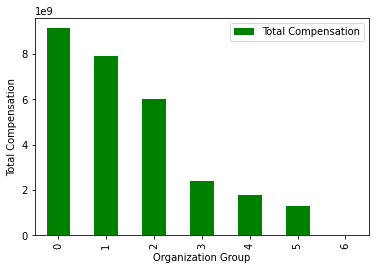

Text(0, 0.5, 'Total Compensation')

In [0]:
top_org = emp_com_df.groupBy("Organization Group").sum('Total Compensation')
top_org = top_org.withColumnRenamed('sum(Total Compensation)','Total Compensation')
top_org = top_org.sort(top_org['Total Compensation'].desc())

top_org.toPandas().plot(kind='bar', color='green')
plt.xlabel("Organization Group")
plt.ylabel("Total Compensation")

#### 5.2. Find top Compensating Jobs. Display using bar plot

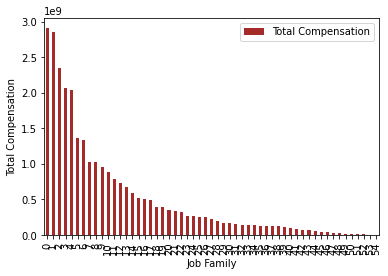

In [0]:
top_org = emp_com_df.groupBy("Job Family").sum('Total Compensation')
top_org = top_org.withColumnRenamed('sum(Total Compensation)','Total Compensation')
top_org = top_org.sort(top_org['Total Compensation'].desc())

f = plt.figure()
f.set_figwidth(4)
f.set_figheight(3)

top_org.toPandas().plot(kind='bar', color='brown')
plt.xlabel("Job Family")
plt.ylabel("Total Compensation")
plt.show()

#### 5.3. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

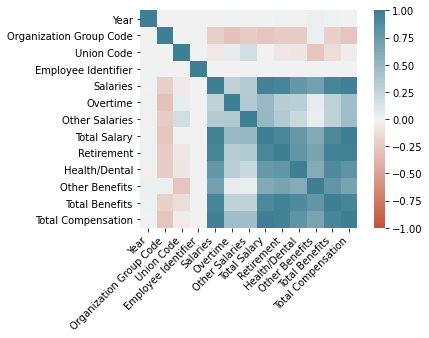

In [0]:
corr = emp_com_df.toPandas().corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

* We observed the columns Salaries, Total Salary, Retrirement, Total Benefits, Health/Dental, Other Benefits have more influence on the taget variable i.e. Total Compensation
* We will remove the  remaining variables

### 6. Perform necessary data pre-processing and divide the data into train and test set

In [0]:
columns_to_exist = ['Employee Identifier', 'Salaries', 'Total Salary', 'Retirement', 'Total Benefits', 'Health/Dental', 'Other Benefits', 'Total Compensation', 'Organization Group Code','Department Code','Union Code','Job Family Code', 'Job Code']
emp_com_df = emp_com_df.select([column for column in columns_to_exist])
emp_com_df = emp_com_df.withColumnRenamed('Employee Identifier',"EmpId")
emp_com_df = emp_com_df.withColumnRenamed('Total Salary',"TotalSal")
emp_com_df = emp_com_df.withColumnRenamed('Total Benefits',"TotalBen")
emp_com_df = emp_com_df.withColumnRenamed('Other Benefits',"OtherBen")
emp_com_df = emp_com_df.withColumnRenamed('Total Compensation',"TotalCompensation")
emp_com_df = emp_com_df.withColumnRenamed('Organization Group Code',"OrganizationGroupCode")
emp_com_df = emp_com_df.withColumnRenamed('Union Code',"UnionCode")
emp_com_df = emp_com_df.withColumnRenamed('Job Family Code',"JobFamilyCode")
emp_com_df = emp_com_df.withColumnRenamed('Job Code',"JobCode")
display(emp_com_df)

EmpId,Salaries,TotalSal,Retirement,TotalBen,Health/Dental,OtherBen,TotalCompensation,OrganizationGroupCode,Department Code,UnionCode,JobFamilyCode,JobCode
49919,114473,115973,21025,43463,13068,9368,159436,1,DAT,311,8100,8177
1225,84077,84077,16587,35976,12457,6931,120054,5,ART,790,1800,1844
34873,9980,10778,0,3090,2254,835,13868,4,DPH,535,2900,2903
51145,2873,2873,0,845,622,222,3718,4,DPH,250,2200,2202
48705,6701,6878,0,3250,2711,538,10128,5,REC,790,3200,3279
19801,45321,45321,9386,24652,11780,3486,69974,2,DPW,21,5300,5380
14135,28305,29498,6616,14840,5793,2430,44339,5,LIB,790,3600,3610
37352,39938,40738,8685,19231,7269,3277,59969,6,ASR,21,4200,4261
13380,23112,46368,4183,6163,1911,68,52532,1,POL,911,Q000,Q060
46569,89101,101521,17596,31736,12512,1627,133258,1,SHF,498,8300,8304


### 6.1 Categorise the attributes into its type (Use one hot encoding wherever required)

In [0]:
emp_com_df.dtypes

Out[334]: [('EmpId', 'int'),
 ('Salaries', 'int'),
 ('TotalSal', 'int'),
 ('Retirement', 'int'),
 ('TotalBen', 'int'),
 ('Health/Dental', 'int'),
 ('OtherBen', 'int'),
 ('TotalCompensation', 'int'),
 ('OrganizationGroupCode', 'int'),
 ('Department Code', 'string'),
 ('UnionCode', 'int'),
 ('JobFamilyCode', 'string'),
 ('JobCode', 'string')]

In [0]:
int_features=[]
str_features=[]

for column in emp_com_df.dtypes:
  if column[1] == 'string':
    str_features.append(column[0])
  else:
    int_features.append(column[0])
    

_stages = []

##Imputer
null_impute = Imputer(inputCols= int_features, outputCols=int_features) 
_stages += [null_impute]

##Encoder
str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
_stages += str_indexer

#Assembler
assembler_input = [f for f in int_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
_stages += [feature_vector]

#Vector Encoder
vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
_stages += [vect_indexer]

LR = LinearRegression(featuresCol='features_indexed', 
                      labelCol= 'TotalCompensation',
                     maxIter=10,
                     regParam=0.3,
                     elasticNetParam=0.8)

### 6.2 Split the data into train and test set

In [0]:
df_train, df_test = emp_com_df.randomSplit([0.7, 0.3], seed=42)
df_test = df_test.drop('TotalCompensation')
# Appending a SalePrice column with 0 literal value
df_test = df_test.withColumn("TotalCompensation", lit(0))

In [0]:
print("Number of rows in train set : ",df_train.count() ,"\nNumber of columns in train set : ", len(df_train.columns))
print("Number of rows in test : ",df_test.count() ,"\nNumber of columns in test set: ", len(df_test.columns))

Number of rows in train set : 204113 
Number of columns in train set : 13
Number of rows in test : 86821 
Number of columns in test set: 13

### 7. Fit Linear Regression model on the data and check its performance

In [0]:
ml_pipeline = Pipeline(stages=_stages + [LR])
lr_model = ml_pipeline.fit(df_train)

In [0]:
lr_predictions = lr_model.transform(df_test)
lr_predictions.select("EmpId","prediction","features").show(5)


+-----+------------------+--------------------+
EmpId| prediction| features|
+-----+------------------+--------------------+
 3|31133.024045119997|[3.0,24912.0,2577...|
 6| 44795.22377451066|[6.0,38884.0,4023...|
 8| 86803.25861080755|[8.0,62934.0,8639...|
 13|143809.76071350253|[13.0,130961.0,14...|
 16| 9945.99264450921|[16.0,8235.0,8235...|
+-----+------------------+--------------------+
only showing top 5 rows

### 8. Fit Decision Tree Regression model on the data and check its performance (Optional)

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features_indexed', labelCol = 'TotalCompensation', maxBins=2000)
ml_pipeline = Pipeline(stages=_stages + [dt])
dt_model = ml_pipeline.fit(df_train)

dt_predictions = dt_model.transform(df_test)

In [0]:
dt_predictions.select("EmpId","prediction","features").show(5)

+-----+------------------+--------------------+
EmpId| prediction| features|
+-----+------------------+--------------------+
 3|1763.1371908539431|[3.0,24912.0,2577...|
 6|1763.1371908539431|[6.0,38884.0,4023...|
 8|1763.1371908539431|[8.0,62934.0,8639...|
 13|1763.1371908539431|[13.0,130961.0,14...|
 16|1763.1371908539431|[16.0,8235.0,8235...|
+-----+------------------+--------------------+
only showing top 5 rows

### Model Persistence (Optional)
Model persistence means saving your model to a disk. After you finalize your model for prediction depending upon the performance, you need to save the model to the disk. Let's say, you finalize 'lrmodel' to be used for in production environment i.e. in your application. We use the following code to save it.

##### Saving the model

In [0]:
# use save() method to save the model
# write().overwrite() is usually used when you want to replace the older model with a new one
# It might happen that you wish to retrain your model and save it at the same the place
lr_model.write().overwrite().save("/FileStore/models/lrmodel")

##### Loading the model

In [0]:
# load the model from the location it is stored
# The loaded model acts as PipelineModel
pipemodel = PipelineModel.load("/FileStore/models/lrmodel")

# use the PipelineModel object to perform prediciton on test data. 
# Use .transform() to perfrom prediction
prediction = pipemodel.transform(df_test)

# print the results
prediction.select("EmpId","prediction","features").show(5)

+-----+------------------+--------------------+
EmpId| prediction| features|
+-----+------------------+--------------------+
 3|31133.024045119997|[3.0,24912.0,2577...|
 6| 44795.22377451066|[6.0,38884.0,4023...|
 8| 86803.25861080755|[8.0,62934.0,8639...|
 13|143809.76071350253|[13.0,130961.0,14...|
 16| 9945.99264450921|[16.0,8235.0,8235...|
+-----+------------------+--------------------+
only showing top 5 rows